<a href="https://colab.research.google.com/github/DGuilherme/PMTese/blob/main/ConvolutionalTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installers

In [1]:
!pip install transformers torch
!pip install pandas scikit-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt

# Read Dataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')

column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]

# Load the dataset
# /content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt
train_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt/train_FD001.txt', delim_whitespace=True, header=None)
test_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_FD001.txt/test_FD001.txt', delim_whitespace=True, header=None)
rul_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/RUL_FD001.txt/RUL_FD001.txt', delim_whitespace=True, header=None)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-62a81ff78bb3>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt/train_FD001.txt', delim_whitespace=True, header=None)
<ipython-input-3-62a81ff78bb3>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_FD001.txt/test_FD001.txt', delim_whitespace=True, header=None)
<ipython-input-3-62a81ff78bb3>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/RUL_FD001.txt/RUL_FD001.txt', 

In [4]:
train_data.columns = column_names
test_data.columns = column_names
rul_data.columns = ['RUL']

print('---------------------Train Data---------------------')
print(train_data.head())
print('---------------------Test Data----------------------')
print(test_data.head())
print('----------------------RUL Data----------------------')
print(rul_data.head())

sensor_cols = train_data.columns[2:]  # Exclude 'id' and 'cycle'

scaler = StandardScaler()
train_data.iloc[:, 5:] = scaler.fit_transform(train_data.iloc[:, 5:])
test_data.iloc[:, 5:] = scaler.transform(test_data.iloc[:, 5:])

# Generate RUL for training data
max_cycle = train_data.groupby('id')['cycle'].max()
train_data = train_data.merge(max_cycle.reset_index(), on='id', suffixes=('', '_max'))
train_data['RUL'] = train_data['cycle_max'] - train_data['cycle']
train_data.drop(columns=['cycle_max'], inplace=True)

# Calculate RUL for the test data
max_cycle_test = test_data.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id', 'max_cycle']
rul_data.columns = ['RUL']
max_cycle_test['RUL'] = rul_data['RUL']
test_data = test_data.merge(max_cycle_test, on='id')
test_data['RUL'] = test_data['RUL'] + test_data['max_cycle'] - test_data['cycle']
test_data.drop(columns=['max_cycle'], inplace=True)

# Now test_data['RUL'] has the correct RUL values, and you won't pass it to the scaler

print('---------------------Train Data---------------------')
print(train_data.head())
print('---------------------Test Data----------------------')
print(test_data.head())

<ipython-input-4-b49d75945ca7>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.78170979 -0.78170979 -2.07309423 ...  3.09244354  1.15536688
  1.8010591 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.iloc[:, 5:] = scaler.fit_transform(train_data.iloc[:, 5:])


---------------------Train Data---------------------
   id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0   1      1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1   1      2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2   1      3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3   1      4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4   1      5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   

   sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  sensor16  \
0  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195      0.03   
1  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318      0.03   
2  1404.20    14.62  ...    522.42   2388.03   8133.23    8.4178      0.03   
3  1401.87    14.62  ...    522.86   2388.08   8133.83    8.3682      0.03   
4  1406.22    14.62  ...    522.19   2388.04   8133.80    8.4294      0.03   

   sensor17  sensor18  sensor19  sensor

<ipython-input-4-b49d75945ca7>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.78170979 -0.13601757 -0.13601757 ...  1.15536688  1.15536688
  1.8010591 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_data.iloc[:, 5:] = scaler.transform(test_data.iloc[:, 5:])


---------------------Train Data---------------------
   id  cycle  setting1  setting2  setting3  sensor1   sensor2   sensor3  \
0   1      1   -0.0007   -0.0004     100.0      0.0 -1.721725 -0.134255   
1   1      2    0.0019   -0.0003     100.0      0.0 -1.061780  0.211528   
2   1      3   -0.0043    0.0003     100.0      0.0 -0.661813 -0.413166   
3   1      4    0.0007    0.0000     100.0      0.0 -0.661813 -1.261314   
4   1      5   -0.0019   -0.0002     100.0      0.0 -0.621816 -1.251528   

    sensor4       sensor5  ...  sensor13  sensor14  sensor15      sensor16  \
0 -0.925936 -1.776357e-15  ... -1.058890 -0.269071 -0.603816 -1.387779e-17   
1 -0.643726 -1.776357e-15  ... -0.363646 -0.642845 -0.275852 -1.387779e-17   
2 -0.525953 -1.776357e-15  ... -0.919841 -0.551629 -0.649144 -1.387779e-17   
3 -0.784831 -1.776357e-15  ... -0.224597 -0.520176 -1.971665 -1.387779e-17   
4 -0.301518 -1.776357e-15  ... -0.780793 -0.521748 -0.339845 -1.387779e-17   

   sensor17  sensor18  sens

# Create Sequences

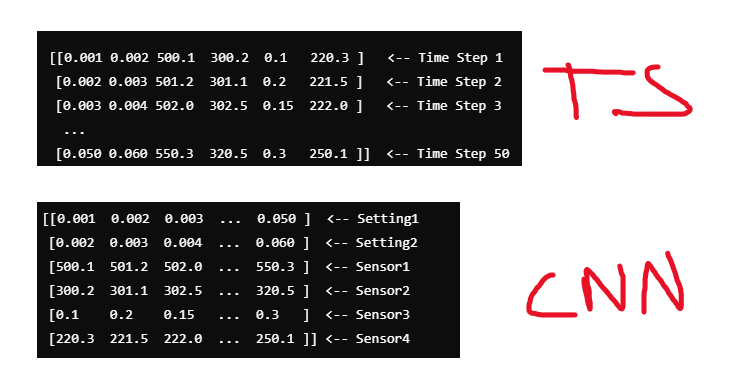

In [5]:
# Prepare sequences for the transformer model
def create_sequences_cnn(data, seq_length=50):
    sequences = []
    for unit in data['id'].unique():
        unit_data = data[data['id'] == unit].reset_index(drop=True)
        for start in range(len(unit_data) - seq_length + 1):
            end = start + seq_length
            seq_X = unit_data.iloc[start:end, 2:-1].values.T  # Select settings and sensor columns
            seq_y = unit_data.iloc[end-1]['RUL']
            sequences.append((seq_X, seq_y))
    return sequences

seq_length = 50
train_sequences = create_sequences_cnn(train_data, seq_length)
test_sequences = create_sequences_cnn(test_data, seq_length)

# Split training data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(
    [seq[0] for seq in train_sequences],
    [seq[1] for seq in train_sequences],
    test_size=0.2,
    random_state=42
)

# Convert to numpy arrays
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)
test_X = np.array([seq[0] for seq in test_sequences])
test_y = np.array([seq[1] for seq in test_sequences])

# Convert to PyTorch tensors
import torch
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
val_X = torch.tensor(val_X, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

In [6]:
print("train_X shape:", train_X.shape)  # Should be (num_samples, num_features, seq_length)
print("train_y shape:", train_y.shape)  # Should be (num_samples,)
print("First train_X sample:\n", train_X[0])  # Print first input sequence
print("First train_y sample:", train_y[0])    # Print corresponding RUL

train_X shape: torch.Size([12584, 24, 50])
train_y shape: torch.Size([12584])
First train_X sample:
 tensor([[ 3.3000e-03,  3.0000e-04,  2.1000e-03,  ..., -8.0000e-04,
         -3.8000e-03, -1.1000e-03],
        [ 3.0000e-04,  1.0000e-04,  4.0000e-04,  ..., -2.0000e-04,
          3.0000e-04, -2.0000e-04],
        [ 1.0000e+02,  1.0000e+02,  1.0000e+02,  ...,  1.0000e+02,
          1.0000e+02,  1.0000e+02],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 8.5055e-01,  6.2924e-01,  7.9522e-01,  ..., -8.6461e-01,
         -5.3264e-01, -4.2199e-01],
        [ 4.2213e-01,  3.3067e-01,  2.9649e-01,  ..., -3.7142e-01,
         -1.6038e+00, -4.9983e-01]])
First train_y sample: tensor(32.)


In [14]:
class ConvTransformer(nn.Module):
    def __init__(self, input_dim, seq_length, conv_channels=64, transformer_dim=None, num_heads=4, num_layers=2, dropout=0.1):
        super(ConvTransformer, self).__init__()

        # 1. Convolutional Feature Extractor
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=conv_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        self.conv_relu = nn.ReLU()

        # Ensure Transformer Dim Matches Conv Output
        if transformer_dim is None:
            transformer_dim = conv_channels  # Match CNN output channels

        # 2. Transformer Encoder
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_length, transformer_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 3. Fully Connected Output Layer
        self.fc = nn.Linear(transformer_dim, 1)

    def forward(self, x):
        # Apply CNN layers (input: [batch, features, sequence])
        x = self.conv_relu(self.conv_bn(self.conv1(x)))
        x = self.conv_relu(self.conv_bn(self.conv2(x)))

        # Reshape for Transformer input: [batch, seq_length, features]
        x = x.permute(0, 2, 1)  # (batch, conv_channels, seq_length) → (batch, seq_length, conv_channels)

        # Add Positional Encoding
        x = x + self.pos_embedding[:, :x.shape[1], :]

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Global Average Pooling & Output
        x = torch.mean(x, dim=1)  # Pooling
        x = self.fc(x).squeeze()  # Output single RUL value
        return x




In [15]:
from torch.utils.data import Dataset, DataLoader

class TurbofanDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # Already in (batch, features, seq_length)
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define batch size
batch_size = 64

# Create dataset objects
train_dataset = TurbofanDataset(train_X, train_y)
val_dataset = TurbofanDataset(val_X, val_y)
test_dataset = TurbofanDataset(test_X, test_y)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [16]:
import torch.optim as optim
import numpy as np

# Define RMSE Loss Function
def rmse_loss(y_pred, y_true):
    return torch.sqrt(nn.MSELoss()(y_pred, y_true))

def train_model(model, train_loader, val_loader, epochs=50, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()  # Use MSE Loss
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val)
                val_loss += criterion(val_outputs, y_val).item()

        # Compute average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved!")

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    predictions = []
    actuals = []
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred = model(X_test)
            predictions.extend(y_pred.cpu().numpy())
            actuals.extend(y_test.cpu().numpy())

    # Compute RMSE
    rmse = np.sqrt(np.mean((np.array(predictions) - np.array(actuals)) ** 2))
    print(f"Test RMSE: {rmse:.4f}")
    return predictions, actuals


In [17]:
# Initialize Model
input_dim = train_X.shape[1]  # Number of features
seq_length = train_X.shape[2]  # Sequence length

model = ConvTransformer(input_dim=input_dim, seq_length=seq_length)

# Train the Model
train_model(model, train_loader, val_loader, epochs=50, lr=0.001)

# Load Best Model
model.load_state_dict(torch.load("best_model.pth"))

# Evaluate
predictions, actuals = evaluate_model(model, test_loader)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50 - Train Loss: 8404.8005 - Val Loss: 6460.4619
Model saved!
Epoch 2/50 - Train Loss: 5256.6898 - Val Loss: 3929.4805
Model saved!
Epoch 3/50 - Train Loss: 2868.0947 - Val Loss: 3308.5589
Model saved!
Epoch 4/50 - Train Loss: 1758.3488 - Val Loss: 4019.8638


KeyboardInterrupt: 